# Gastcollege trainen met vermogen

In [1]:
from io import StringIO

from athletic_pandas.models import Athlete, WorkoutDataFrame
from goldencheetahlib.client import GoldenCheetahClient
from lmfit import Parameters, minimize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import requests

%matplotlib inline

## Formules

$P = CP + W'/t$

$W = P \cdot t$

## Power duration plot

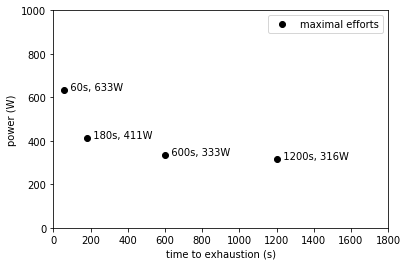

In [2]:
def power_duration_plot_init():
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xlabel('time to exhaustion (s)')
    ax.set_ylabel('power (W)')
    ax.set_xlim(0, 1800)
    ax.set_ylim(0, 1000)
    return fig, ax

def power_duration_plot_points(fig, ax, annotate=False):
    durations = [60, 180, 600, 1200]
    maximale_inspanningen = [durations, [300 + 20000/t for t in durations]]
    ax.plot(maximale_inspanningen[0], maximale_inspanningen[1], 'ko')
    if annotate:
        for tijd, vermogen in zip(maximale_inspanningen[0], maximale_inspanningen[1]):
            ax.annotate('  {}s, {}W'.format(int(tijd), int(vermogen)), xy=(tijd, vermogen), textcoords='data')
    
    ax.legend(['maximal efforts'])
    return fig, ax

fig, ax = power_duration_plot_init()
fig_power_duration_plot_points_annotated, ax = power_duration_plot_points(fig, ax, annotate=True)

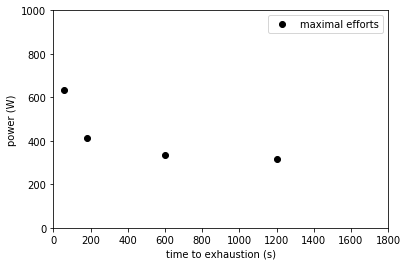

In [3]:
fig, ax = power_duration_plot_init()
fig_power_duration_plot_points, ax = power_duration_plot_points(fig, ax)

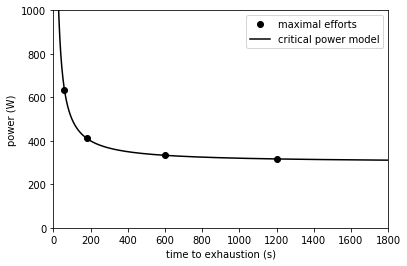

In [4]:
def power_duration_plot_curve(fig, ax):
    time_axis = range(1, 1800)
    power_duration_curve=[20000/t + 300 for t in time_axis]
    ax.plot(time_axis, power_duration_curve, 'k-')
    if ax.legend_:
        existing_legend = [text.get_text() for text in ax.legend_.get_texts()]
    else:
        existing_legend = []
    ax.legend(existing_legend + ['critical power model'])

    return fig, ax

fig, ax = power_duration_plot_init()
fig, ax = power_duration_plot_points(fig, ax)
fig_power_duration_plot_curve, ax = power_duration_plot_curve(fig, ax)

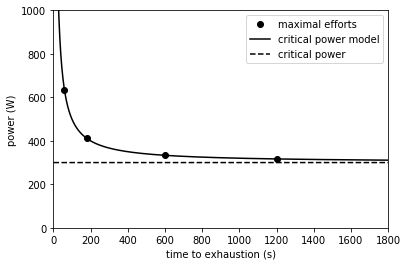

In [5]:
def power_duration_plot_cp_asymptote(fig, ax):
    time_axis = range(1, 1800)
    critical_power = [300]*len(time_axis)
    ax.plot(time_axis, critical_power, 'k--')
    if ax.legend_:
        existing_legend = [text.get_text() for text in ax.legend_.get_texts()]
    else:
        existing_legend = []
    ax.legend(existing_legend + ['critical power'])
    return fig, ax

fig, ax = power_duration_plot_init()
fig, ax = power_duration_plot_points(fig, ax)
fig, ax = power_duration_plot_curve(fig, ax)
fig_power_duration_plot_cp_asymptote, ax = power_duration_plot_cp_asymptote(fig, ax)

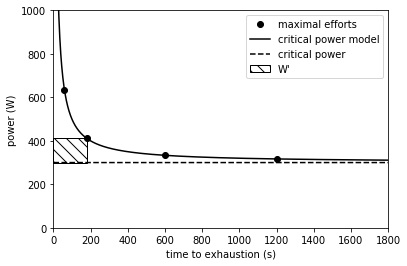

In [6]:
def power_duration_plot_single_patch(fig, ax, duration, hatch):
    ax.add_patch(
        patches.Rectangle(
            (0, 300), duration, 20000/duration,
            color='k',
            fill=False,
            hatch=hatch
        )
    )
    if ax.legend_:
        existing_legend = [text.get_text() for text in ax.legend_.get_texts()]
    else:
        existing_legend = []
    ax.legend(existing_legend + ['W\'', 'W\'', 'W\''])
    return fig, ax

fig, ax = power_duration_plot_init()
fig, ax = power_duration_plot_points(fig, ax)
fig, ax = power_duration_plot_curve(fig, ax)
fig, ax = power_duration_plot_cp_asymptote(fig, ax)
fig_power_duration_plot_single_patch, ax = power_duration_plot_single_patch(fig, ax, duration=180, hatch='\\\\')

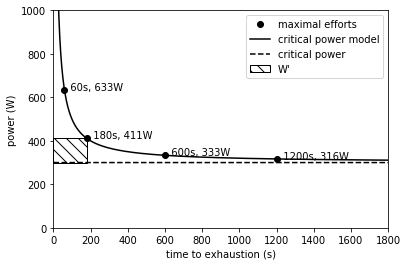

In [7]:
fig, ax = power_duration_plot_init()
fig, ax = power_duration_plot_points(fig, ax, annotate=True)
fig, ax = power_duration_plot_curve(fig, ax)
fig, ax = power_duration_plot_cp_asymptote(fig, ax)
fig_power_duration_plot_single_patch_annotated, ax = power_duration_plot_single_patch(fig, ax, duration=180, hatch='\\\\')

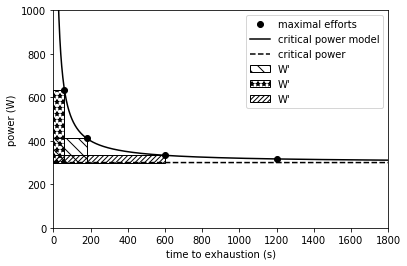

In [8]:
fig, ax = power_duration_plot_init()
fig, ax = power_duration_plot_points(fig, ax)
fig, ax = power_duration_plot_curve(fig, ax)
fig, ax = power_duration_plot_cp_asymptote(fig, ax)
fig, ax = power_duration_plot_single_patch(fig, ax, duration=180, hatch='\\\\')
fig, ax = power_duration_plot_single_patch(fig, ax, duration=60, hatch='**')
fig_power_duration_plot_multiple_patches, ax = power_duration_plot_single_patch(fig, ax, duration=600, hatch='/////')

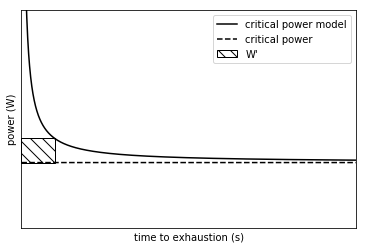

In [9]:
fig, ax = power_duration_plot_init()
fig, ax = power_duration_plot_curve(fig, ax)
fig, ax = power_duration_plot_cp_asymptote(fig, ax)
fig_power_duration_plot_clean, ax = power_duration_plot_single_patch(fig, ax, duration=180, hatch='\\\\')
ax.set_xticks([])
ax.set_yticks([]);

## Power duration plot with work

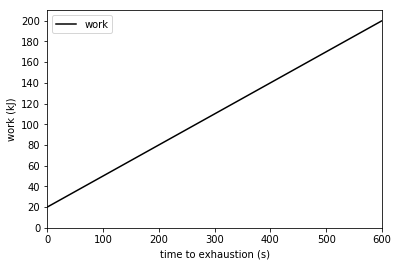

In [10]:
fig_power_duration_work = plt.figure()
ax = fig_power_duration_work.add_subplot(111)
ax.set_xlabel('time to exhaustion (s)')
ax.set_ylabel('work (kJ)')
ax.set_xlim(0, 600)
ax.set_ylim(0, 210)
ax.set_yticks(range(0, 210, 20))
time_axis = np.arange(1, 600)
work = 20 + 0.3*time_axis
ax.plot(time_axis, work, 'k-')
ax.legend(['work']);

$ W = W' + CP \cdot t$

## 3-parameter model

$ P = \frac{W'}{t} + CP $

$ P = \frac{W'}{t + \frac{W'}{Pmax - CP}} + CP $

In [11]:
def pd_model_2_param_predict(model_params, duration):
    return model_params['cp'] + model_params['w_prime'] / duration


def pd_model_2_param_residuals(model_params, duration, power):
    model = pd_model_2_param_predict(model_params, duration)
    return power - model


def pd_model_2_param(duration, power):
    model_params = Parameters()
    model_params.add_many(
        ('cp', 340),
        ('w_prime', 340),
    )

    model = minimize(
        fcn=pd_model_2_param_residuals,
        params=model_params,
        method='leastsq',
        args=(duration, power)
    )

    predictions = pd_model_2_param_predict(model.params, duration)

    return model, predictions


def pd_model_3_param_predict(model_params, duration):
    return model_params['w_prime'] / (duration + (model_params['w_prime'] / (model_params['p_max'] - model_params['cp']))) + model_params['cp']


def pd_model_3_param_residuals(model_params, duration, power):
    model = pd_model_3_param_predict(model_params, duration)
    return power - model


def pd_model_3_param(duration, power):
    model_params = Parameters()
    model_params.add_many(
        ('cp', 340),
        ('w_prime', 20000),
        ('p_max', 1500),
    )

    model = minimize(
        fcn=pd_model_3_param_residuals,
        params=model_params,
        method='leastsq',
        args=(duration, power)
    )

    predictions = pd_model_3_param_predict(model.params, duration)

    return model, predictions

Model 2 params
cp: 357.2620206733392
w_prime: 15892.706625508712

Model 3 params
cp: 317.3009018586129
w_prime: 36907.5240429063
p_max: 870.6092242844335


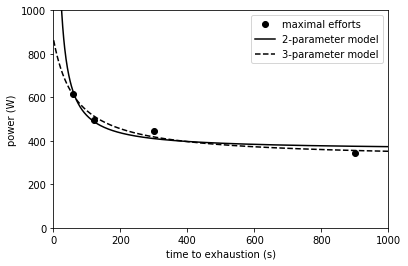

In [12]:
durations = np.array(
    [60, 120, 300, 900]
)
power = np.array(
    [615, 495, 443, 344]
)

model_2, _ = pd_model_2_param(durations, power)
model_3, _ = pd_model_3_param(durations, power)

time_axis = np.arange(1, 1000)
power_2_param = pd_model_2_param_predict(model_2.params, time_axis)
power_3_param = pd_model_3_param_predict(model_3.params, time_axis)

fig_3_param = plt.figure()
ax = fig_3_param.add_subplot(111)
ax.plot(durations, power, 'ko')
ax.plot(time_axis, power_2_param, 'k')
ax.plot(time_axis, power_3_param, 'k--')

ax.set_xlim(0, max(time_axis))
ax.set_ylim(0, 1000)
ax.legend(['maximal efforts', '2-parameter model', '3-parameter model'])
ax.set_xlabel('time to exhaustion (s)')
ax.set_ylabel('power (W)')
print('Model 2 params')
[print('{}: {}'.format(key, model_2.params[key].value)) for key in model_2.params.keys()]
print('\nModel 3 params')
[print('{}: {}'.format(key, model_3.params[key].value)) for key in model_3.params.keys()];

Model 2 params
cp: 345.85338321957875
w_prime: 19130.075244099207

Model 3 params
cp: 142.8923766816146
w_prime: 365781.39918357425
p_max: 540.9853587115666


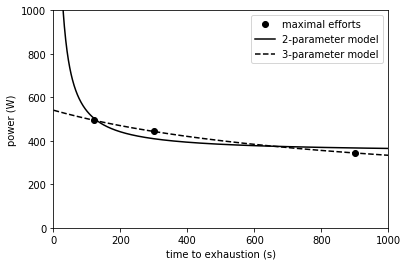

In [13]:
durations = np.array(
    [120, 300, 900]
)
power = np.array(
    [495, 443, 344]
)

model_2, _ = pd_model_2_param(durations, power)
model_3, _ = pd_model_3_param(durations, power)

time_axis = np.arange(1, 1000)
power_2_param = pd_model_2_param_predict(model_2.params, time_axis)
power_3_param = pd_model_3_param_predict(model_3.params, time_axis)

fig_3_param_wrong = plt.figure()
ax = fig_3_param_wrong.add_subplot(111)
ax.plot(durations, power, 'ko')
ax.plot(time_axis, power_2_param, 'k')
ax.plot(time_axis, power_3_param, 'k--')

ax.set_xlim(0, max(time_axis))
ax.set_ylim(0, 1000)
ax.legend(['maximal efforts', '2-parameter model', '3-parameter model'])
ax.set_xlabel('time to exhaustion (s)')
ax.set_ylabel('power (W)')
print('Model 2 params')
[print('{}: {}'.format(key, model_2.params[key].value)) for key in model_2.params.keys()]
print('\nModel 3 params')
[print('{}: {}'.format(key, model_3.params[key].value)) for key in model_3.params.keys()];

## Power profile test

Athlete A params
cp: 290.4135337969922
w_prime: 38720.300747211295

Athlete B params
cp: 336.2969925145209
w_prime: 24895.488719522033


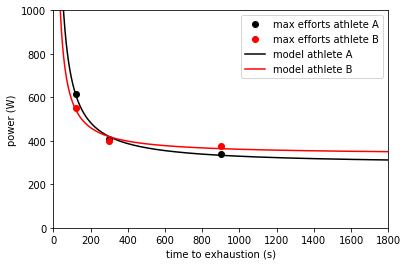

In [14]:
durations = np.array(
    [120, 300, 900]
)
power_a = np.array(
    [616, 410, 340]
)
power_b = np.array(
    [550, 399, 378]
)

model_a, _ = pd_model_2_param(durations, power_a)
model_b, _ = pd_model_2_param(durations, power_b)

time_axis = np.arange(1, 30*60)
power_a_predicted = pd_model_2_param_predict(model_a.params, time_axis)
power_b_predicted = pd_model_2_param_predict(model_b.params, time_axis)

fig_power_profile = plt.figure()
ax = fig_power_profile.add_subplot(111)
ax.plot(durations, power_a, 'ko')
ax.plot(durations, power_b, 'ro')
ax.plot(time_axis, power_a_predicted, 'k')
ax.plot(time_axis, power_b_predicted, 'r')

ax.set_xlim(0, max(time_axis))
ax.set_ylim(0, 1000)
ax.legend(['max efforts athlete A', 'max efforts athlete B', 'model athlete A', 'model athlete B'])
ax.set_xlabel('time to exhaustion (s)')
ax.set_ylabel('power (W)')
print('Athlete A params')
[print('{}: {}'.format(key, model_a.params[key].value)) for key in model_a.params.keys()]
print('\nAthlete B params')
[print('{}: {}'.format(key, model_b.params[key].value)) for key in model_b.params.keys()];

## Mean max power curve

In [16]:
resp = requests.get('http://localhost:12021/aart/meanmax/bests/?since=2017/12/01')
mean_max_bests = pd.read_csv(StringIO(resp.text))

Model params
cp: 290.4135337969922
w_prime: 38720.300747211295


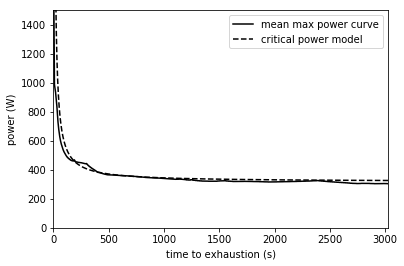

In [17]:
durations = mean_max_bests['secs'][120:1200].values
power = mean_max_bests[' watts'][120:1200].values

model, _ = pd_model_2_param(durations, power)

time_axis = np.arange(1, max(mean_max_bests['secs'].values))
power_predicted = pd_model_2_param_predict(model.params, time_axis)

fig_mean_max_power = plt.figure()
ax = fig_mean_max_power.add_subplot(111)
ax.plot(mean_max_bests['secs'].values, mean_max_bests[' watts'].values, 'k')
ax.plot(time_axis, power_predicted, 'k--')

ax.set_xlim(0, max(time_axis))
ax.set_ylim(0, 1500)
ax.legend(['mean max power curve', 'critical power model'])
ax.set_xlabel('time to exhaustion (s)')
ax.set_ylabel('power (W)')
print('Model params')
[print('{}: {}'.format(key, model_a.params[key].value)) for key in model_a.params.keys()];

## 3 minute all out test

In [18]:
# De volgende code is alleen nodig als je de trainingsdata direct uit de GoldenCheetah REST API wilt halen
gc_client = GoldenCheetahClient('Martijn Veling')
wdf = gc_client._request_activity_data('Martijn Veling', '2016_11_08_16_43_08.json')
wdf = wdf.set_index(wdf.index.seconds)
wdf = wdf.sort_index()
cropped_wdf = wdf.iloc[60:240]
cropped_wdf.to_json('3_minute_all_out.json')

In [19]:
wdf_3_minute_all_out = WorkoutDataFrame(pd.read_json('3_minute_all_out.json'))
wdf_3_minute_all_out = wdf_3_minute_all_out.sort_index()

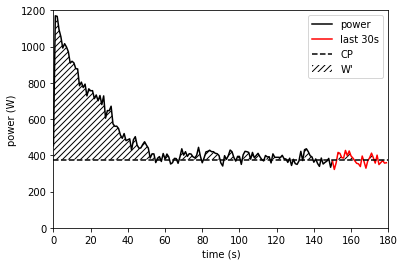

In [20]:
fig_3_min_all_out = plt.figure()
ax = fig_3_min_all_out.add_subplot(111)
ax.set_xlabel('time (s)')
ax.set_ylabel('power (W)')
ax.set_xlim(0, 180)
ax.set_ylim(0, 1200)

ax.plot(range(151), wdf_3_minute_all_out.power[:151].values, 'k')
ax.plot(range(150, 180), wdf_3_minute_all_out[150:].power.values, 'r')
ax.fill_between(
    x=range(180),
    y1=wdf_3_minute_all_out.power.values,
    y2=wdf_3_minute_all_out[150:].power.mean(),
    where=wdf_3_minute_all_out.power.values >= wdf_3_minute_all_out[150:].power.mean(),
    facecolor='none',
    linewidth=0.0,
    hatch='////'
)
ax.plot([0, 180], [wdf_3_minute_all_out[150:].power.mean()]*2, 'k--')
ax.legend(['power', 'last 30s', 'CP', 'W\'']);

## "W'balance in de praktijk"

### Eerste voorbeeld: 20-minuten test

In [39]:
# De volgende code is alleen nodig als je de trainingsdata direct uit de GoldenCheetah REST API wilt halen
# gc_client = GoldenCheetahClient('Aart')
# wdf = gc_client._request_activity_data('Aart', '2017_08_08_18_04_50.json')
# wdf = wdf.set_index(wdf.index.seconds)
# wdf.athlete = Athlete(cp=315, w_prime=18000)
# wdf = wdf.assign(w_bal=np.array(wdf.w_prime_balance()))
# cropped_wdf = wdf[1700:3000]
# cropped_wdf.to_json('20_minute_test.json')
# ...anders kun je de data ook gewoon vanuit het '20_minute_test.json'-bestand laden met het code-blok hieronder.

In [21]:
wdf_20_minute = WorkoutDataFrame(pd.read_json('20_minute_test.json'))
wdf_20_minute.athlete = Athlete(cp=315, w_prime=18000)

In [22]:
start = 1769
wdf_20_minute.loc[start:start + 1200].power.mean()

337.08992506244795

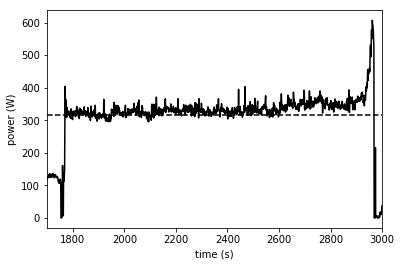

In [23]:
fig_20_minute_power = plt.figure(figsize=(6, 4))

xlim = (wdf_20_minute.index.min(), wdf_20_minute.index.max())

ax = fig_20_minute_power.add_subplot(111, xlim=xlim)
ax.plot(wdf_20_minute.index, wdf_20_minute.power, 'k-')
ax.plot(list(xlim), [wdf_20_minute.athlete.cp, wdf_20_minute.athlete.cp], 'k--')
ax.set_ylabel('power (W)')
ax.set_xlabel('time (s)');

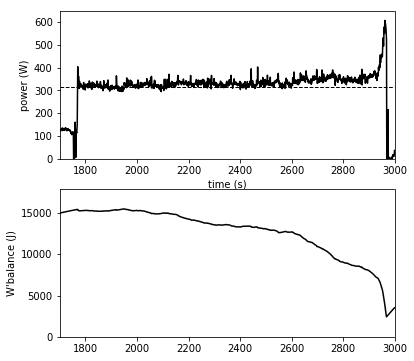

In [24]:
fig_20_minute = plt.figure(figsize=(6, 6))

xlim = (wdf_20_minute.index.min(), wdf_20_minute.index.max())

ax1 = fig_20_minute.add_subplot(211, xlim=xlim, ylim=(0, 650))
ax1.plot(wdf_20_minute.index, wdf_20_minute.power, 'k-')
ax1.plot(list(xlim), [wdf_20_minute.athlete.cp, wdf_20_minute.athlete.cp], 'k--', lw=1)
ax1.set_ylabel('power (W)')

ax2 = fig_20_minute.add_subplot(212, xlim=xlim, ylim=(0, wdf_20_minute.athlete.w_prime))
ax2.plot(wdf_20_minute.index, wdf_20_minute.w_bal, 'k-')
ax2.set_ylabel('W\'balance (J)')
ax1.set_xlabel('time (s)');

### Tweede voorbeeld: intervaltraining

In [25]:
# De volgende code is alleen nodig als je de trainingsdata direct uit de GoldenCheetah REST API wilt halen
# gc_client = GoldenCheetahClient('Aart')
# wdf_interval_workout = gc_client._request_activity_data('Aart', '2017_10_11_18_11_37.json')
# wdf_interval_workout = wdf_interval_workout.set_index(wdf_interval_workout.index.seconds)
# wdf_interval_workout.athlete = Athlete(cp=340, w_prime=20000)
# wdf_interval_workout = wdf_interval_workout.assign(w_bal=np.array(wdf_interval_workout.w_prime_balance()))
# cropped_wdf = wdf_interval_workout[1200:]
# cropped_wdf.to_json('interval_training.json')
# ...anders kun je de data ook gewoon vanuit het '20_minute_test.json'-bestand laden met het code-blok hieronder.

In [26]:
wdf_interval_workout = WorkoutDataFrame(pd.read_json('interval_training.json'))
wdf_interval_workout.athlete = Athlete(cp=340, w_prime=20000)

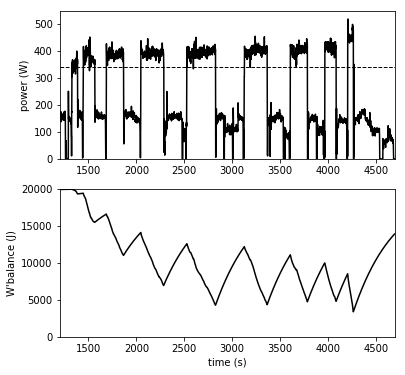

In [27]:
fig_interval_workout = plt.figure(figsize=(6,6))

xlim = (wdf_interval_workout.index.min(), wdf_interval_workout.index.max())

ax1 = fig_interval_workout.add_subplot(211, xlim=xlim, ylim=(0, 550))
ax1.plot(wdf_interval_workout.index, wdf_interval_workout.power, 'k-')
ax1.plot(list(xlim), [wdf_interval_workout.athlete.cp, wdf_interval_workout.athlete.cp], 'k--', lw=1)
ax1.set_ylabel('power (W)')

ax2 = fig_interval_workout.add_subplot(212, xlim=xlim, ylim=(0, wdf_interval_workout.athlete.w_prime))
ax2.plot(wdf_interval_workout.index, wdf_interval_workout.w_bal, 'k-')
ax2.set_ylabel('W\'balance (J)')
ax2.set_xlabel('time (s)');

## "Trainingen Ontwerpen"

### Casus 1

In [191]:
athlete = Athlete(cp=300, w_prime=20000)

def vermogen_casus_1(vermogen):
    warming_up = [100]*600
    interval = ([vermogen]*60 + [0]*60)*5
    rust = [0]*240
    cooling_down = [100]*600
    return warming_up + interval + rust + interval + rust + interval + cooling_down

wdf_case_1 = WorkoutDataFrame()
wdf_case_1.athlete = athlete

wdf_case_1 = wdf_case_1.assign(power=vermogen_casus_1(350))
wdf_case_1 = wdf_case_1.assign(w_bal_350=wdf_case_1.compute_w_prime_balance())

wdf_case_1 = wdf_case_1.assign(power=vermogen_casus_1(365))
wdf_case_1 = wdf_case_1.assign(w_bal_365=wdf_case_1.compute_w_prime_balance())

wdf_case_1 = wdf_case_1.assign(power=vermogen_casus_1(380))
wdf_case_1 = wdf_case_1.assign(w_bal_380=wdf_case_1.compute_w_prime_balance())

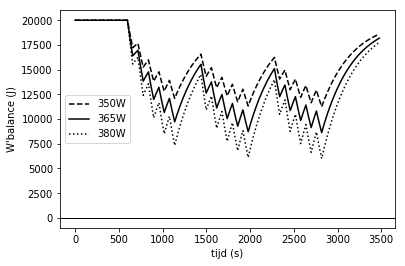

In [192]:
fig_case_1 = wdf_case_1.loc[:, ['w_bal_350', 'w_bal_365', 'w_bal_380']].plot(
    style=['k--', 'k-', 'k:']
)
fig_case_1.legend(['350W', '365W', '380W'])
fig_case_1.set_xlabel('tijd (s)')
fig_case_1.set_ylabel('W\'balance (J)')
fig_case_1.axhline(0, color='k', lw=1);

In [168]:
for i in ['350', '365', '380']:
    min_w_bal = getattr(wdf_case_1, 'w_bal_'+i).min()
    print('Minimale W\'bal voor {vermogen}W: {min_w_bal}J ({perc}%)'.format(
        vermogen=i,
        min_w_bal=round(min_w_bal),
        perc=round(min_w_bal/wdf_case_1.athlete.w_prime*100, 1)
    ))

Minimale W'bal voor 350W: 6014.0J (30.1%)
Minimale W'bal voor 365W: 1819.0J (9.1%)
Minimale W'bal voor 380W: -2377.0J (-11.9%)


### Casus 2

In [193]:
athlete = Athlete(cp=300, w_prime=20000)
vo2_vermogen = athlete.cp + athlete.w_prime/(8*60)

def vermogen_casus_2(rust_lengte):
    warming_up = [100]*600
    interval = [vo2_vermogen]*300
    rust = [0]*rust_lengte
    cooling_down = [100]*600
    return warming_up + interval + rust + interval + rust + interval + rust + interval + cooling_down

short = 300
long = 720

wdf_case_2 = WorkoutDataFrame()
wdf_case_2.athlete = athlete
wdf_case_2 = wdf_case_2.assign(power=vermogen_casus_2(short) + [0.]*(long-short)*3)
wdf_case_2 = wdf_case_2.assign(w_bal_5m_rust=wdf_case_2.compute_w_prime_balance())

wdf_case_2 = wdf_case_2.assign(power=vermogen_casus_2(long))
wdf_case_2 = wdf_case_2.assign(w_bal_12m_rust=wdf_case_2.compute_w_prime_balance())

Text(0,0.5,"W'balance (J)")

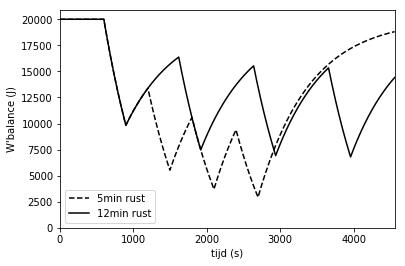

In [170]:
fig_case_2 = wdf_case_2.loc[:, ['w_bal_5m_rust', 'w_bal_12m_rust']].plot(
    ylim=0,
    style=['k--', 'k-']
)
fig_case_2.legend(['5min rust', '12min rust'], loc=3)
fig_case_2.set_xlabel('tijd (s)')
fig_case_2.set_ylabel('W\'balance (J)')

In [171]:
w_bal_voor_tweede_5m = wdf_case_2.w_bal_5m_rust[600 + 300 + 300]
print('W\'bal voorafgaand aan tweede interval bij 5 min rust: {w_bal}J ({perc}%)'.format(
        w_bal=round(w_bal_voor_tweede_5m),
        perc=round(w_bal_voor_tweede_5m/wdf_case_2.athlete.w_prime*100)
))

w_bal_voor_laatste_12m = wdf_case_2.w_bal_12m_rust[600 + 3*300 + 3*720]
print('W\'bal voorafgaand aan laatste interval bij 12 min rust: {w_bal}J ({perc}%)'.format(
        w_bal=round(w_bal_voor_laatste_12m),
        perc=round(w_bal_voor_laatste_12m/wdf_case_2.athlete.w_prime*100)
))

W'bal voorafgaand aan tweede interval bij 5 min rust: 13352.0J (67.0%)
W'bal voorafgaand aan laatste interval bij 12 min rust: 15305.0J (77.0%)


### Casus 3

In [172]:
athlete = Athlete(cp=300, w_prime=20000)

def vermogen_casus_3(rust_lengte):
    warming_up = [100]*600
    interval = [athlete.cp*1.40]*60
    rust = [0]*rust_lengte
    cooling_down = [100]*600
    return warming_up + (interval + rust)*8 + cooling_down

short = 120
middle = 240
long = 300

wdf_case_3 = WorkoutDataFrame()
wdf_case_3.athlete = athlete
wdf_case_3 = wdf_case_3.assign(power=vermogen_casus_3(short) + [0.]*((long-short)*8))
wdf_case_3 = wdf_case_3.assign(w_bal_120=wdf_case_3.w_prime_balance())

wdf_case_3 = wdf_case_3.assign(power=vermogen_casus_3(middle) + [0.]*((long-middle)*8))
wdf_case_3 = wdf_case_3.assign(w_bal_240=wdf_case_3.w_prime_balance())

wdf_case_3 = wdf_case_3.assign(power=vermogen_casus_3(long))
wdf_case_3 = wdf_case_3.assign(w_bal_300=wdf_case_3.w_prime_balance())

Text(0,0.5,"W'balance (J)")

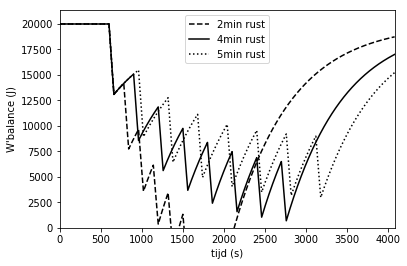

In [173]:
fig_case_3 = wdf_case_3.loc[:, ['w_bal_120', 'w_bal_240', 'w_bal_300']].plot(
    ylim=0,
    style=['k--', 'k-', 'k:']
)
fig_case_3.legend(['2min rust', '4min rust', '5min rust'])
fig_case_3.set_xlabel('tijd (s)')
fig_case_3.set_ylabel('W\'balance (J)')

In [174]:
for i in ['120', '240', '300']:
    min_w_bal = getattr(wdf_case_3, 'w_bal_'+i).min()
    print('Minimale W\'bal voor {rust} min rust: {min_w_bal}J ({perc}%)'.format(
        rust=int(int(i)/60),
        min_w_bal=round(min_w_bal),
        perc=round(min_w_bal/wdf_case_3.athlete.w_prime*100)
    ))

Minimale W'bal voor 2 min rust: -6729.0J (-34.0%)
Minimale W'bal voor 4 min rust: 689.0J (3.0%)
Minimale W'bal voor 5 min rust: 2979.0J (15.0%)


# Critical power roeier fitten

In [28]:
def pace_to_watt(pace):
    """
    pace in decimal seconds/meter
    """
    return 2.8 / (pace**3)

In [47]:
duration = np.array([82, 182, 375])

distance = np.array([500, 1000, 2000])

power = pace_to_watt(duration / distance)
print(power)

model_rower, _ = pd_model_2_param(duration, power)

print('\nModel params:')
[print('{}: {}'.format(key, model_rower.params[key].value)) for key in model_rower.params.keys()];

[634.78475356 464.45524045 424.77037037]

Model params:
cp: 354.306303624763
w_prime: 22651.050871892177


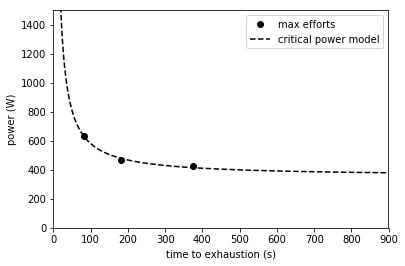

In [46]:
time_axis = np.arange(1, 900)

power_predicted = pd_model_2_param_predict(
    model_rower.params,
    time_axis
)

fig_rower = plt.figure()
ax = fig_rower.add_subplot(111)
ax.plot(duration, power, 'ko')
ax.plot(time_axis, power_predicted, 'k--')

ax.set_xlim(0, max(time_axis))
ax.set_ylim(0, 1500)
ax.legend(['max efforts', 'critical power model'])
ax.set_xlabel('time to exhaustion (s)')
ax.set_ylabel('power (W)');

# Afbeeldingen exporteren

In [190]:
figures = [
    fig_power_duration_plot_points_annotated,
    fig_power_duration_plot_points,
    fig_power_duration_plot_curve,
    fig_power_duration_plot_cp_asymptote,
    fig_power_duration_plot_single_patch,
    fig_power_duration_plot_single_patch_annotated,
    fig_power_duration_plot_multiple_patches,
    fig_power_duration_plot_clean,
    fig_power_duration_work,
    fig_3_param,
    fig_3_param_wrong,
    fig_power_profile,
    fig_mean_max_power,
    fig_3_min_all_out,
    fig_20_minute_power,
    fig_20_minute,
    fig_interval_workout
]
figure_names = [
    'pd_points_annotated',
    'pd_points',
    'pd_curve',
    'pd_asymptote',
    'pd_w_prime',
    'pd_w_prime_annotated',
    'pd_w_primes',
    'pd_clean',
    'pd_work',
    'pd_3_param',
    'pd_3_param_wrong',
    'power_profile',
    'mean_max_curve',
    '3_min_all_out',
    'fig_20_minute_power',
    'fig_20_minute',
    'fig_interval_workout'
]
for fig, name in zip(figures, figure_names):
    if hasattr(fig, 'savefig'):
        f = fig
    elif isinstance(fig, np.ndarray):
        f = fig[0].get_figure()
    else:
        f = fig.get_figure()
    f.set_size_inches(6, 4)
    f.savefig(name + '.png', dpi=900, transparent=True)